## Финальный проект по базам данных

В учебных целях в качестве данных для базы данных я взяла данные о фильмах с https://www.kinopoisk.ru. Данные я выбирала с сайта вручную, ознакомиться с собранными данными можно ниже. При желании можно собрать краулером с сайта данные, а затем сразу положить в базу данных, убрав мусор. В учебных целях я собрала небольшой датасет сама (27 записей).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('movies.csv', sep = ',')
df[:5]

,Режиссер,Фильм,Год,Описание,Страна,Рейтинг
0,Ридли Скотт,Дом Gucci,2021,"Фамилия Гуччи звучала так сладко, так соблазни...","Канада, США",6.9
1,Ридли Скотт,Все деньги мира,2017,История одного из самых громких скандалов XX в...,"США, Италия, Великобритания, Китай",6.8
2,Лана Вачовски,Матрица: Воскрешение,2021,В двух реальностях Нео снова придется выбирать...,США,7.0
3,Андрей Тарковский,Солярис,1972,"На космическую станцию, сотрудники которой дав...",СССР,8.0
4,Андрей Тарковский,Сталкер,1979,"В некой запретной Зоне, по слухам, существует ...",СССР,8.1


### Схема базы данных
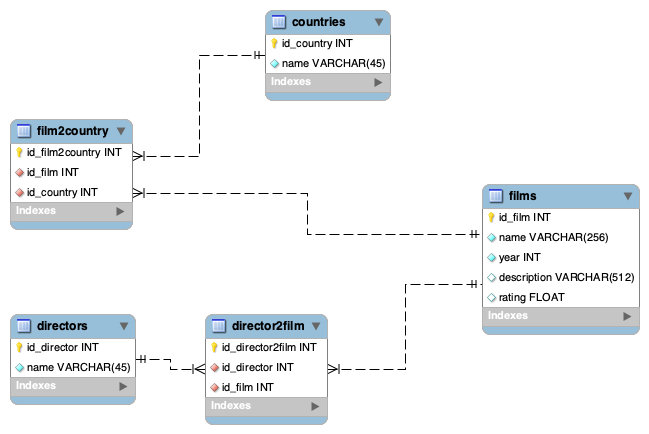

In [3]:
# !pip3 install mysql-connector-python

In [5]:
import mysql.connector

Создадим пустую базу данных.

In [8]:
con = mysql.connector.connect(host='127.0.0.1', port=33069, user='root', password='my-secret-pw')

In [9]:
cur=con.cursor(dictionary=True)

In [10]:
cur.execute("CREATE database project")

База данных готова! Теперь добавим в нее таблички из схемы и запишем наши данные.

In [6]:
con = mysql.connector.connect(host='127.0.0.1', port=33069, database='project', user='root', password='my-secret-pw')

In [7]:
cur=con.cursor(dictionary=True)

### Таблица с фильмами

In [13]:
cur.execute("""CREATE TABLE films (
  id_film INT NOT NULL AUTO_INCREMENT,
  name VARCHAR(256) NOT NULL,
  year INT NOT NULL,
  description VARCHAR(1024) NULL,
  rating FLOAT NULL,
  PRIMARY KEY (id_film));
""")

In [14]:
%%time
for film in range(0, len(df)):
    id_film = film + 1
    name_value = df['Фильм'][film]
    year_value = df['Год'][film]
    desc_value = df['Описание'][film]
    rating_value = df['Рейтинг'][film]
    try:
        info = f"INSERT INTO films (name, year, description, rating) VALUES ('{name_value}', '{year_value}', '{desc_value}', '{rating_value}')"
        cur.execute(info)
    except:
         print("Error - INSERT INTO films (name, year, description, rating) VALUES ('"+name+"', '"+year+"', '"+desc+"', '"+rating+"')")
    con.commit()

CPU times: user 12.6 ms, sys: 6.48 ms, total: 19.1 ms
Wall time: 671 ms


### Таблица со странами

In [15]:
cur.execute("""CREATE TABLE countries (
  id_country INT NOT NULL AUTO_INCREMENT,
  name VARCHAR(45) NOT NULL,
  PRIMARY KEY (id_country));
""")

In [16]:
countries = []
for i in df['Страна']:
    for c in i.split(', '):
        countries.append(c)
unique_countries = set(countries)

In [17]:
%%time
for country_value in unique_countries:
    try:
        info = f"INSERT INTO countries (name) VALUES ('{country_value}')"
        cur.execute(info)
    except:
         print("Error - INSERT INTO countries (name) VALUES ('"+country_value+"')")
    con.commit()

CPU times: user 6.2 ms, sys: 4.83 ms, total: 11 ms
Wall time: 459 ms


### Таблица с режиссерами

In [18]:
cur.execute("""CREATE TABLE directors (
  id_director INT NOT NULL AUTO_INCREMENT,
  name VARCHAR(45) NOT NULL,
  PRIMARY KEY (id_director));
""")

In [19]:
directors = []
for i in df['Режиссер']:
    directors.append(i)
unique_directors = set(directors)

In [20]:
%%time
for director_value in unique_directors:
    try:
        info = f"INSERT INTO directors (name) VALUES ('{director_value}')"
        cur.execute(info)
    except:
         print("Error - INSERT INTO directors (name) VALUES ('"+director_value+"')")
    con.commit()

CPU times: user 6.21 ms, sys: 4.48 ms, total: 10.7 ms
Wall time: 509 ms


### Таблицы связей: film2country и director2film

Они нужны по той причине, что 1) одному фильму может соответствовать несколько стран и 2) одному режиссеру может соответствовать несколько фильмов

In [21]:
cur.execute("""CREATE TABLE film2country (
  id_film2country INT NOT NULL AUTO_INCREMENT,
  id_film INT NOT NULL,
  id_country INT NOT NULL,
  PRIMARY KEY (id_film2country),
  INDEX id_film1_idx (id_film ASC) VISIBLE,
  INDEX id_country_idx (id_country ASC) VISIBLE,
  CONSTRAINT id_film1
    FOREIGN KEY (id_film)
    REFERENCES films (id_film)
    ON UPDATE CASCADE
    ON DELETE CASCADE,
  CONSTRAINT id_country
    FOREIGN KEY (id_country)
    REFERENCES countries (id_country)
    ON UPDATE CASCADE
    ON DELETE CASCADE);
""")

In [22]:
ids_countries = {}
for num, value in enumerate(unique_countries):
    ids_countries[value]=num+1

In [23]:
%%time
for num, i in enumerate(df['Страна']):
    for c in i.split(', '):
        film_values = num+1
        country_value = ids_countries[c]
        try:
            info = f"INSERT INTO film2country (id_film, id_country) VALUES ('{film_values}', '{country_value}')"
            cur.execute(info)
        except:
             print("Error - INSERT INTO film2country (id_film, id_country) VALUES ('"+film_values+"', '"+country_value+"')")
        con.commit()

CPU times: user 15.9 ms, sys: 9.48 ms, total: 25.4 ms
Wall time: 1.55 s


In [24]:
cur.execute("""CREATE TABLE director2film (
  id_director2film INT NOT NULL AUTO_INCREMENT,
  id_director INT NOT NULL,
  id_film INT NOT NULL,
  PRIMARY KEY (id_director2film),
  INDEX id_director_idx (id_director ASC) VISIBLE,
  INDEX id_film2_idx (id_film ASC) VISIBLE,
  CONSTRAINT id_director
    FOREIGN KEY (id_director)
    REFERENCES project.directors (id_director)
    ON UPDATE CASCADE
    ON DELETE CASCADE,
  CONSTRAINT id_film2
    FOREIGN KEY (id_film)
    REFERENCES films (id_film)
    ON UPDATE CASCADE
    ON DELETE CASCADE);
""")

In [25]:
ids_directors = {}
for num, value in enumerate(unique_directors):
    ids_directors[value]=num+1

In [26]:
for num, i in enumerate(df['Фильм']):
    name = df['Режиссер'][num]
    name_value = ids_directors[name]
    film_value = num+1
    try:
        info = f"INSERT INTO director2film (id_director, id_film) VALUES ('{name_value}', '{film_value}')"
        cur.execute(info)
    except:
        print("Error - INSERT INTO director2film (id_director, id_film) VALUES ('"+name_value+"', '"+film_value+"')")
    con.commit()

Посмотрим, что получилось:

In [8]:
cur.execute("SELECT * FROM films")
data=cur.fetchall()
data[:3]

[{'id_film': 1,
  'name': 'Дом Gucci',
  'year': 2021,
  'description': 'Фамилия Гуччи звучала так сладко, так соблазнительно. Синоним роскоши, стиля, власти. Но она же была их проклятьем. Шокирующая история любви, предательства, падения и мести, которая привела к жестокому убийству в одной из самых знаменитых модных империй мира.',
  'rating': 6.9},
 {'id_film': 2,
  'name': 'Все деньги мира',
  'year': 2017,
  'description': 'История одного из самых громких скандалов XX века. В Риме преступники в масках похищают внука Жана Пола Гетти — богатейшего человека мира, известного своей маниакальной скупостью. Ко всеобщему шоку Гетти отказывается платить выкуп, несмотря на все мольбы Гэйл, матери ребенка, которой никакие богатства не заменят сына. Время истекает, требования похитителей становятся жёстче, и единственной надеждой на спасение подростка становится Флетчер Чейс — сотрудник службы безопасности самого Гетти.',
  'rating': 6.8},
 {'id_film': 3,
  'name': 'Матрица: Воскрешение',
  'y

In [9]:
cur.execute("SELECT * FROM directors")
data=cur.fetchall()
data[:3]

[{'id_director': 1, 'name': 'Роберт Земекис'},
 {'id_director': 2, 'name': 'Андрей Тарковский'},
 {'id_director': 3, 'name': 'Ларс фон Триер'}]

In [10]:
cur.execute("SELECT * FROM director2film")
data=cur.fetchall()
data[:3]

[{'id_director2film': 1, 'id_director': 18, 'id_film': 1},
 {'id_director2film': 2, 'id_director': 18, 'id_film': 2},
 {'id_director2film': 3, 'id_director': 9, 'id_film': 3}]

Попробуем удалить данные из таблицы films. Все данные по ней удалятся и из других таблиц, в которых есть какие-либо упоминания этого фильма (тк они связаны по fk).

In [13]:
cur.execute("DELETE FROM project.films WHERE name = 'Солярис'")
con.commit()

И изменим какую-нибудь запись.

In [20]:
cur.execute("""UPDATE project.films
SET name = 'Последствия',
year = '2019',
description = 'Германия после Второй мировой войны. В стране беспорядок, разруха, голод. Главный герой — британский военный Льюис Морган, который назначен временным мэром Гамбурга. Ему предстоит восстанавливать город почти с нуля. Вместе с женой Льюис селится в роскошный особняк, где живет немецкий архитектор с эмоционально нестабильной дочерью. Смогут ли бывшие враги ужиться под одной крышей или желание отомстить будет сильнее?',
rating = '6.4'
WHERE id_film = '1';""")
con.commit()

- Проблема: данные в таблице film2country не изменятся (фильму с таким айди все еще будут соответствовать
страны того фильма, который был на его месте). 
- Комментарий: реальные данные, которые связаны с данными из других таблиц лучше не изменять таким образом.
Логичнее удалить все данные по тому, что мы хотим заменить из всех таблиц, а затем добавить что-то новое 
во все нужные таблицы.

In [21]:
cur.execute("SELECT * FROM project.films")
data=cur.fetchall()

In [22]:
results = pd.DataFrame(columns=list(data[0].keys()))
results = results.append(data[0:], ignore_index=True)
results[:5]

,id_film,name,year,description,rating
0,1,Последствия,2019,Германия после Второй мировой войны. В стране ...,6.4
1,2,Все деньги мира,2017,История одного из самых громких скандалов XX в...,6.8
2,3,Матрица: Воскрешение,2021,В двух реальностях Нео снова придется выбирать...,7.0
3,5,Сталкер,1979,"В некой запретной Зоне, по слухам, существует ...",8.1
4,6,Внутренняя империя,2006,Актеры Никки Грейс и Девон Берк приступают к с...,6.9


Все записалось и то, что надо удалилось, попробуем выполнить запросы к базе данных.

### Примеры запросов
5. SELECT с несколькими (от трех) таблицами в условии выборки (1 балл)
6. Вложенные SELECT (2 балла)
7. Запросы с JOIN (2 балла)
8. Аггрегация, сортировки (2 балл)

Выведем данные по фильмам, у которых рейтинг выше 8-ми, и их режиссеров. Чтобы вывести имена режиссеров, нам нужно обратиться к связывающей таблице director2film. Для удобства будем выводить результаты табличкой.

In [32]:
cur.execute("""SELECT films.name, directors.name director, films.description, films.rating
FROM project.films, project.director2film, project.directors
WHERE films.id_film = director2film.id_film
AND directors.id_director = director2film.id_director
AND films.rating > 8;""")
data=cur.fetchall()
data[:3]

[{'name': 'Сталкер',
  'director': 'Андрей Тарковский',
  'description': 'В некой запретной Зоне, по слухам, существует комната, где исполняются самые заветные желания. К этой комнате отправляются модный Писатель и авторитетный Профессор — каждый по своим причинам, о которых предпочитают не говорить. А ведет их туда Сталкер — проводник по Зоне — то ли юродивый, то ли апостол новой веры.',
  'rating': 8.1},
 {'name': 'Психо',
  'director': 'Альфред Хичкок',
  'description': 'Мэрион Крэйн недовольна романом с разведенным мужчиной, который уделяет ей внимание только наездами. Поэтому девушка крадет на работе крупную сумму и в спешке бежит из города. Мэрион останавливается на ночь в мотеле, которым управляет Норман Бейтс — юноша, страдающий от гнёта своей горячо любимой, но деспотичной матери.',
  'rating': 8.5},
 {'name': 'Форрест Гамп',
  'director': 'Роберт Земекис',
  'description': 'Сидя на автобусной остановке, Форрест Гамп — не очень умный, но добрый и открытый парень — рассказывает

In [33]:
results = pd.DataFrame(columns=list(data[0].keys()))
results = results.append(data[0:], ignore_index=True)
results

,name,director,description,rating
0,Сталкер,Андрей Тарковский,"В некой запретной Зоне, по слухам, существует ...",8.1
1,Психо,Альфред Хичкок,Мэрион Крэйн недовольна романом с разведенным ...,8.5
2,Форрест Гамп,Роберт Земекис,"Сидя на автобусной остановке, Форрест Гамп — н...",8.8
3,Криминальное чтиво,Квентин Тарантино,Двое бандитов Винсент Вега и Джулс Винфилд вед...,8.9
4,Персона,Ингмар Бергман,Знаменитая актриса внезапно перестает разговар...,8.1
5,Отель «Гранд Будапешт»,Уэс Андерсон,Фильм рассказывает об увлекательных приключени...,8.1
6,"Париж, Техас",Вим Вендерс,"Идущий ниоткуда Трэвис знает, что у него есть ...",8.1
7,Паразиты,Пон Джун-хо,Обычное корейское семейство Кимов жизнь не бал...,8.6
8,Амели,Жан-Пьер Жёне,"Знаете ли вы, что все события, происходящие в ...",8.3
9,Красота по-американски,Сэм Мендес,Лестер Бернэм переживает кризис среднего возра...,8.3


Сделаем то же самое, но с JOIN, добавим условие на год фильма и количество слов в описании.

In [36]:
cur.execute("""SELECT films.name, directors.name director, year, description, rating, LENGTH(TRIM(films.description)) - LENGTH(REPLACE(TRIM(films.description), ' ', '')) + 1 len_desc
FROM project.director2film
JOIN project.directors ON director2film.id_director=directors.id_director
JOIN project.films ON director2film.id_film=films.id_film
WHERE films.rating > 8 
AND year > 1990
AND LENGTH(TRIM(films.description)) - LENGTH(REPLACE(TRIM(films.description), ' ', '')) + 1 > 50
ORDER BY year DESC;""")
data=cur.fetchall()
data[:3]

[{'name': 'Паразиты',
  'director': 'Пон Джун-хо',
  'year': 2019,
  'description': 'Обычное корейское семейство Кимов жизнь не балует. Приходится жить в сыром грязном полуподвале, воровать интернет у соседей и перебиваться случайными подработками. Однажды друг сына семейства, уезжая на стажировку за границу, предлагает тому заменить его и поработать репетитором у старшеклассницы в богатой семье Пак. Подделав диплом о высшем образовании, парень отправляется в шикарный дизайнерский особняк и производит на хозяйку дома хорошее впечатление. Тут же ему в голову приходит необычный план по трудоустройству сестры.',
  'rating': 8.6,
  'len_desc': 72},
 {'name': 'Амели',
  'director': 'Жан-Пьер Жёне',
  'year': 2001,
  'description': 'Знаете ли вы, что все события, происходящие в нашем мире, даже самые незначительные, взаимосвязаны самым удивительным и чудесным образом?\nКак полет крошечной мухи может вызвать где-то далеко мощный ураган, так и странные и, на первый взгляд, непонятные поступки 

In [37]:
results = pd.DataFrame(columns=list(data[0].keys()))
results = results.append(data[0:], ignore_index=True)
results

,name,director,year,description,rating,len_desc
0,Паразиты,Пон Джун-хо,2019,Обычное корейское семейство Кимов жизнь не бал...,8.6,72
1,Амели,Жан-Пьер Жёне,2001,"Знаете ли вы, что все события, происходящие в ...",8.3,67
2,Красота по-американски,Сэм Мендес,1999,Лестер Бернэм переживает кризис среднего возра...,8.3,75
3,Форрест Гамп,Роберт Земекис,1994,"Сидя на автобусной остановке, Форрест Гамп — н...",8.8,61
4,Криминальное чтиво,Квентин Тарантино,1994,Двое бандитов Винсент Вега и Джулс Винфилд вед...,8.9,57


Посмотрим теперь на распределение фильмов по странам, выведем только те страны, которые встречаются больше 2 раз.

In [24]:
cur.execute("""SELECT countries.name, count(*) number
FROM project.film2country
JOIN project.countries ON film2country.id_country=countries.id_country
JOIN project.films ON film2country.id_film=films.id_film
GROUP BY countries.name
HAVING number > 2
ORDER BY number DESC;
""")
data=cur.fetchall()

In [25]:
results = pd.DataFrame(columns=list(data[0].keys()))
results = results.append(data[0:], ignore_index=True)
results

,name,number
0,США,18
1,Германия,9
2,Франция,6
3,Великобритания,5
4,Швеция,3


Теперь мы хотим посмотреть только на фильмы из США. Выведем режиссеров, отсортируем по убыванию рейтинга.

In [40]:
cur.execute("""SELECT directors.name director, films.name, year, description, rating 
FROM project.director2film
JOIN project.directors ON director2film.id_director=directors.id_director
JOIN project.films ON director2film.id_film=films.id_film
WHERE films.id_film in (SELECT films.id_film
FROM project.film2country
JOIN project.countries ON film2country.id_country=countries.id_country
JOIN project.films ON film2country.id_film=films.id_film
WHERE countries.name = 'США')
ORDER BY rating DESC;""")
data=cur.fetchall()

In [41]:
results = pd.DataFrame(columns=list(data[0].keys()))
results = results.append(data[0:], ignore_index=True)
results

,director,name,year,description,rating
0,Квентин Тарантино,Криминальное чтиво,1994,Двое бандитов Винсент Вега и Джулс Винфилд вед...,8.9
1,Роберт Земекис,Форрест Гамп,1994,"Сидя на автобусной остановке, Форрест Гамп — н...",8.8
2,Альфред Хичкок,Психо,1960,Мэрион Крэйн недовольна романом с разведенным ...,8.5
3,Сэм Мендес,Красота по-американски,1999,Лестер Бернэм переживает кризис среднего возра...,8.3
4,Уэс Андерсон,Отель «Гранд Будапешт»,2014,Фильм рассказывает об увлекательных приключени...,8.1
5,Вим Вендерс,"Париж, Техас",1984,"Идущий ниоткуда Трэвис знает, что у него есть ...",8.1
6,Ричард Келли,Донни Дарко,2001,"Донни Дарко — обычный старшеклассник, живет с ...",8.0
7,Уэс Андерсон,Остров собак,2018,"История 12-летнего мальчика Атари Кобаяси, опе...",7.8
8,Уэс Андерсон,Семейка Тененбаум,2001,Все члены семьи Тененбаум обладают уникальными...,7.6
9,Уэс Андерсон,Французский вестник. Приложение к газете «Либе...,2021,"Собрание удивительных историй, опубликованных ...",7.5
